In [1]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tensorflow.python.platform.build_info import build_info
from tensorflow.config.experimental import list_physical_devices, VirtualDeviceConfiguration, set_virtual_device_configuration #type:ignore

from tensorflow.keras.regularizers import l2 #type:ignore
from tensorflow.keras.optimizers import Adam, RMSprop, SGD #type:ignore
from tensorflow.keras.models import Sequential #type:ignore
from tensorflow.keras.losses import CategoricalCrossentropy # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint #type:ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator #type:ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout #type:ignore
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, LeakyReLU, AveragePooling2D #type:ignore
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import load_model #type:ignore

from tensorflow.keras.losses import Loss #type:ignore
from tensorflow.keras import backend as K #type:ignore
from tensorflow.keras.losses import CategoricalFocalCrossentropy #type:ignore
from sklearn.utils.class_weight import compute_class_weight

from pathlib import Path
import os
import shutil
import random

In [2]:
params = {
    'filters': 64,
    'conv_layers': 4,
    'dense_units': 128,
    'dropout': 0.30,
    'batch_norm': True,
    'optimizer': "adam",
    'lr': 1e-3,
    'flattening_layers': "GAP2D",
    'random_state': 42
}

In [ ]:
current_dir = Path(os.getcwd())

data_dir = current_dir.parent / "data"

train_dir = data_dir / "train"
val_dir = data_dir / "valid"
test_dir = data_dir / "test"

model_name = "Sequential_Model"
checkpoints_dir = current_dir.parent / "checkpoints" / model_name
checkpoints_dir.mkdir(parents=True, exist_ok=True)

checkpoint_file_name = model_name + "-1.h5"

print(f"{'Project Root:':<25}{current_dir.parent}")
print(f"{'Train Directory:':<25}{train_dir}")
print(f"{'Validation Directory:':<25}{val_dir}")
print(f"{'Test Directory:':<25}{test_dir}")
print(f"{'Checkpoints Directory:':<25}{checkpoints_dir}")
print(f"{'Checkpoint File Name:':<25}{checkpoint_file_name}")

Project Root:            c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier
Train Directory:         c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\data\train
Validation Directory:    c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\data\valid
Test Directory:          c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\data\test
Checkpoints Directory:   c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\checkpoints\Sequential_Model
Checkpoint File Name:    sequential_model_2.h5


In [59]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False 
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False 
)

Found 2637 images belonging to 9 classes.
Found 760 images belonging to 9 classes.
Found 760 images belonging to 9 classes.
Found 290 images belonging to 9 classes.
Found 290 images belonging to 9 classes.


In [60]:
class_labels = train_generator.classes
class_weight_dict = dict(
    enumerate(
        compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)
    )
)
class_weight_dict

{0: np.float64(4.883333333333334),
 1: np.float64(0.9301587301587302),
 2: np.float64(0.9242902208201893),
 3: np.float64(0.9301587301587302),
 4: np.float64(0.9099378881987578),
 5: np.float64(0.846820809248555),
 6: np.float64(0.9361022364217252),
 7: np.float64(0.8772455089820359),
 8: np.float64(0.9301587301587302)}

In [ ]:
modelcheckpoint = ModelCheckpoint(str(checkpoints_dir / checkpoint_file_name), monitor="val_loss", save_best_only=True, verbose=0)

callbacks = [
    modelcheckpoint,
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.33, patience=2, min_lr=1e-6)
]

model = Sequential()
filters = params['filters']
for i in range(params['conv_layers']):
    if i == 0:
        model.add(Conv2D(filters, (3,3), activation='relu',kernel_regularizer=l2(0.001) ,input_shape=(64, 64, 3)))
    else:
        model.add(Conv2D(filters, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    if params['batch_norm']:
        model.add(BatchNormalization())
    filters *= 2  # Double filters each block
    
if params["flattening_layers"] == "GAP2D":
    model.add(GlobalAveragePooling2D())
    model.add(Dense(params['dense_units'], activation='relu', kernel_regularizer=l2(0.001)))
else:
    model.add(Flatten())
    model.add(Dense(params['dense_units'], activation='relu'))
    
model.add(Dropout(params['dropout']))
model.add(Dense(train_generator.num_classes, activation='softmax'))

if params['optimizer'] == 'adam':
    opt = Adam(learning_rate=params['lr'])
elif params['optimizer'] == 'rmsprop':
    opt = RMSprop(learning_rate=params['lr'])
else:
    opt = SGD(learning_rate=params['lr'], momentum=0.9)
    

model.compile(
    optimizer=opt, 
    loss=CategoricalFocalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.2220 - loss: 0.7286

83/83 ━━━━━━━━━━━━━━━━━━━━ 73s 703ms/step - accuracy: 0.2503 - loss: 0.6515 - val_accuracy: 0.0961 - val_loss: 0.7334 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.3693 - loss: 0.4891

83/83 ━━━━━━━━━━━━━━━━━━━━ 57s 687ms/step - accuracy: 0.3978 - loss: 0.4631 - val_accuracy: 0.1079 - val_loss: 0.7115 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 90s 779ms/step - accuracy: 0.4805 - loss: 0.3955 - val_accuracy: 0.1500 - val_loss: 0.7464 - learning_rate: 0.0010
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 90s 779ms/step - accuracy: 0.4805 - loss: 0.3955 - val_accuracy: 0.1500 - val_loss: 0.7464 - learning_rate: 0.0010
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 63s 758ms/step - accuracy: 0.5294 - loss: 0.3601 - val_accuracy: 0.1145 - val_loss: 0.8237 - learning_rate: 0.0010
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 63s 758ms/step - accuracy: 0.5294 - loss: 0.3601 - val_accuracy: 0.1145 - val_loss: 0.8237 - learning_rate: 0.0010
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 60s 720ms/step - accuracy: 0.6587 - loss: 0.2762 - val_accuracy: 0.1250 - val_loss: 0.7817 - learning_rate: 3.3000e-04
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 60s 720ms/step - accuracy: 0.6587 - loss

83/83 ━━━━━━━━━━━━━━━━━━━━ 62s 747ms/step - accuracy: 0.7254 - loss: 0.2421 - val_accuracy: 0.2184 - val_loss: 0.6198 - learning_rate: 3.3000e-04
Epoch 7/50
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.7573 - loss: 0.2199

83/83 ━━━━━━━━━━━━━━━━━━━━ 63s 763ms/step - accuracy: 0.7463 - loss: 0.2212 - val_accuracy: 0.2592 - val_loss: 0.5480 - learning_rate: 3.3000e-04
Epoch 8/50
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.7911 - loss: 0.2070

83/83 ━━━━━━━━━━━━━━━━━━━━ 63s 764ms/step - accuracy: 0.7846 - loss: 0.2061 - val_accuracy: 0.4066 - val_loss: 0.4396 - learning_rate: 3.3000e-04
Epoch 9/50
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.8095 - loss: 0.1910

83/83 ━━━━━━━━━━━━━━━━━━━━ 57s 691ms/step - accuracy: 0.8013 - loss: 0.1919 - val_accuracy: 0.6105 - val_loss: 0.2944 - learning_rate: 3.3000e-04
Epoch 10/50
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 59s 711ms/step - accuracy: 0.8187 - loss: 0.1825 - val_accuracy: 0.6079 - val_loss: 0.3000 - learning_rate: 3.3000e-04
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 59s 711ms/step - accuracy: 0.8187 - loss: 0.1825 - val_accuracy: 0.6079 - val_loss: 0.3000 - learning_rate: 3.3000e-04
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 61s 739ms/step - accuracy: 0.8464 - loss: 0.1681 - val_accuracy: 0.6461 - val_loss: 0.3100 - learning_rate: 3.3000e-04
Epoch 12/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 61s 739ms/step - accuracy: 0.8464 - loss: 0.1681 - val_accuracy: 0.6461 - val_loss: 0.3100 - learning_rate: 3.3000e-04
Epoch 12/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.8706 - loss: 0.1583

83/83 ━━━━━━━━━━━━━━━━━━━━ 67s 808ms/step - accuracy: 0.8809 - loss: 0.1522 - val_accuracy: 0.7395 - val_loss: 0.2136 - learning_rate: 1.0890e-04
Epoch 13/50
Epoch 13/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.9129 - loss: 0.1409

83/83 ━━━━━━━━━━━━━━━━━━━━ 67s 810ms/step - accuracy: 0.9120 - loss: 0.1401 - val_accuracy: 0.7579 - val_loss: 0.2049 - learning_rate: 1.0890e-04
Epoch 14/50
Epoch 14/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.9101 - loss: 0.1387

83/83 ━━━━━━━━━━━━━━━━━━━━ 66s 797ms/step - accuracy: 0.9033 - loss: 0.1390 - val_accuracy: 0.8118 - val_loss: 0.1789 - learning_rate: 1.0890e-04
Epoch 15/50
Epoch 15/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 66s 793ms/step - accuracy: 0.9245 - loss: 0.1324 - val_accuracy: 0.7316 - val_loss: 0.2137 - learning_rate: 1.0890e-04
Epoch 16/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 66s 793ms/step - accuracy: 0.9245 - loss: 0.1324 - val_accuracy: 0.7316 - val_loss: 0.2137 - learning_rate: 1.0890e-04
Epoch 16/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 66s 788ms/step - accuracy: 0.9116 - loss: 0.1317 - val_accuracy: 0.8066 - val_loss: 0.1840 - learning_rate: 1.0890e-04
Epoch 17/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 66s 788ms/step - accuracy: 0.9116 - loss: 0.1317 - val_accuracy: 0.8066 - val_loss: 0.1840 - learning_rate: 1.0890e-04
Epoch 17/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 62s 748ms/step - accuracy: 0.9405 - loss: 0.1230 - val_accuracy: 0.7842 - val_loss: 0.1851 - learning_rate: 3.5937e-05
Epoch 18/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 62s 748ms/ste

83/83 ━━━━━━━━━━━━━━━━━━━━ 63s 764ms/step - accuracy: 0.9321 - loss: 0.1236 - val_accuracy: 0.8250 - val_loss: 0.1683 - learning_rate: 3.5937e-05
Epoch 19/50
Epoch 19/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 64s 771ms/step - accuracy: 0.9408 - loss: 0.1204 - val_accuracy: 0.8105 - val_loss: 0.1790 - learning_rate: 3.5937e-05
Epoch 20/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 64s 771ms/step - accuracy: 0.9408 - loss: 0.1204 - val_accuracy: 0.8105 - val_loss: 0.1790 - learning_rate: 3.5937e-05
Epoch 20/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 63s 753ms/step - accuracy: 0.9439 - loss: 0.1203 - val_accuracy: 0.8303 - val_loss: 0.1701 - learning_rate: 3.5937e-05
Epoch 21/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 63s 753ms/step - accuracy: 0.9439 - loss: 0.1203 - val_accuracy: 0.8303 - val_loss: 0.1701 - learning_rate: 3.5937e-05
Epoch 21/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.9509 - loss: 0.1181

83/83 ━━━━━━━━━━━━━━━━━━━━ 65s 784ms/step - accuracy: 0.9462 - loss: 0.1188 - val_accuracy: 0.8487 - val_loss: 0.1601 - learning_rate: 1.1859e-05
Epoch 22/50
Epoch 22/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 65s 787ms/step - accuracy: 0.9488 - loss: 0.1173 - val_accuracy: 0.8408 - val_loss: 0.1623 - learning_rate: 1.1859e-05
Epoch 23/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 65s 787ms/step - accuracy: 0.9488 - loss: 0.1173 - val_accuracy: 0.8408 - val_loss: 0.1623 - learning_rate: 1.1859e-05
Epoch 23/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.9518 - loss: 0.1172

83/83 ━━━━━━━━━━━━━━━━━━━━ 58s 697ms/step - accuracy: 0.9499 - loss: 0.1172 - val_accuracy: 0.8539 - val_loss: 0.1569 - learning_rate: 1.1859e-05
Epoch 24/50
Epoch 24/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 58s 704ms/step - accuracy: 0.9579 - loss: 0.1159 - val_accuracy: 0.8368 - val_loss: 0.1648 - learning_rate: 1.1859e-05
Epoch 25/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 58s 704ms/step - accuracy: 0.9579 - loss: 0.1159 - val_accuracy: 0.8368 - val_loss: 0.1648 - learning_rate: 1.1859e-05
Epoch 25/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 62s 752ms/step - accuracy: 0.9579 - loss: 0.1154 - val_accuracy: 0.8579 - val_loss: 0.1583 - learning_rate: 1.1859e-05
Epoch 26/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 62s 752ms/step - accuracy: 0.9579 - loss: 0.1154 - val_accuracy: 0.8579 - val_loss: 0.1583 - learning_rate: 1.1859e-05
Epoch 26/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 58s 698ms/step - accuracy: 0.9515 - loss: 0.1164 - val_accuracy: 0.8474 - val_loss: 0.1596 - learning_rate: 3.9135e-06
Epoch 27/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 58s 698ms/ste

In [62]:
def evaluate_model(model, test_ds, class_names):
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    print(f"\nTest Results:\nAccuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")

    preds = model.predict(test_ds, verbose=1)
    y_pred = np.argmax(preds, axis=1)

    if hasattr(test_ds, 'labels'):
        y_true = test_ds.labels
    else:
        y_true = np.concatenate([np.argmax(y, axis=1) for _, y in test_ds], axis=0)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    print('\nClassification Report:\n')
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    return test_acc, test_loss, y_pred


Test Results:
Accuracy: 0.8138 | Loss: 0.1651
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 531ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 531ms/step


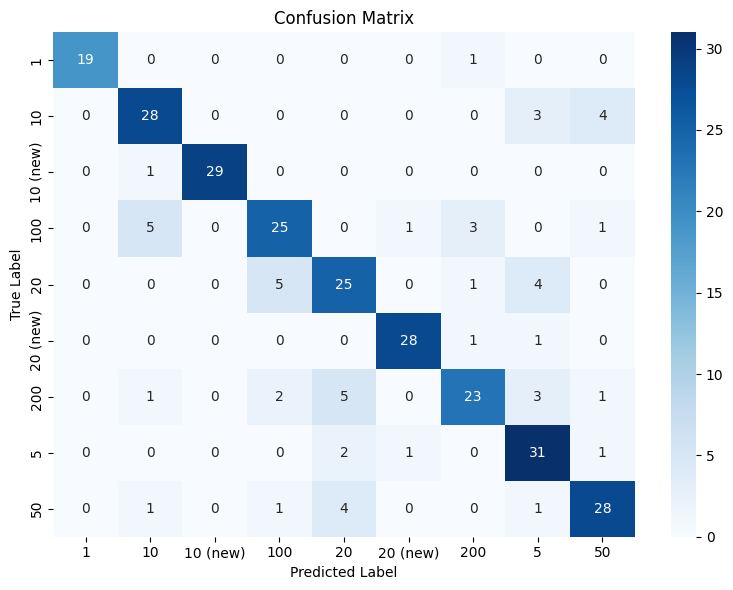


Classification Report:

              precision    recall  f1-score   support

           1     1.0000    0.9500    0.9744        20
          10     0.7778    0.8000    0.7887        35
    10 (new)     1.0000    0.9667    0.9831        30
         100     0.7576    0.7143    0.7353        35
          20     0.6944    0.7143    0.7042        35
    20 (new)     0.9333    0.9333    0.9333        30
         200     0.7931    0.6571    0.7188        35
           5     0.7209    0.8857    0.7949        35
          50     0.8000    0.8000    0.8000        35

    accuracy                         0.8138       290
   macro avg     0.8308    0.8246    0.8258       290
weighted avg     0.8174    0.8138    0.8136       290



In [63]:
test_acc, test_loss, y_pred = evaluate_model(model, test_generator, list(test_generator.class_indices.keys()))

In [64]:
def plot_training_curves(history, test_acc=0):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.plot(epochs_range, acc, label='Train Acc')
    plt.plot(epochs_range, val_acc, label='Val Acc')
    plt.axhline(y=test_acc, linestyle='--', color='green', label=f'Test Acc: {test_acc:.2f}')
    plt.title('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

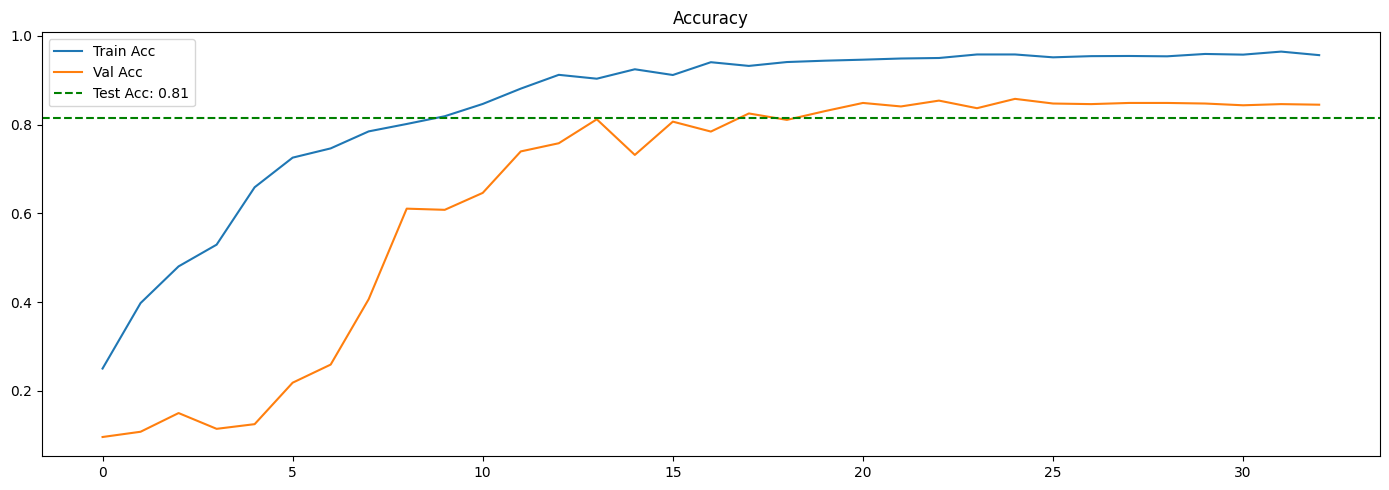

In [65]:
plot_training_curves(history, test_acc=test_acc)